In [1]:
import os
from os.path import realpath, join
import sys
sys.path.insert(0, '/home/chuah/mitsuba3-camera/build/python')

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mi.set_variant('cuda_ad_dispersion')

In [2]:
SCENE_DIR = realpath('../tutorials/scenes')

# Make sure that resources from the scene directory can be found
mi.Thread.thread().file_resolver().append(SCENE_DIR)

In [3]:
output_dir = realpath(join('.', 'outputs', 'lens'))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Results will be saved to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens


# Set lens parameters

In [4]:
def get_exact_Vd(lens_system):
    # https://phys.libretexts.org/Bookshelves/Optics/Geometric_Optics_(Tatum)/02%3A_Lens_and_Mirror_Calculations/2.10%3A_Designing_an_Achromatic_Doublet
    inv_c = lens_system.elements[0].surface.get_curvature()
    inv_b = -lens_system.elements[1].surface.get_curvature()
    inv_a = lens_system.elements[2].surface.get_curvature()
    n1 = lens_system.materials[2].params['ior']
    V1 = lens_system.materials[2].params['V_d']
    n2 = lens_system.materials[1].params['ior']

    P1 = (n1 - 1) * (inv_a + inv_b)
    P2 = -(n2 - 1) * (inv_b + inv_c)

    # P1 / V1 + P2 / V2 = 0
    return -(P2 / P1) * V1

Exact Vd: 6.861593997805768


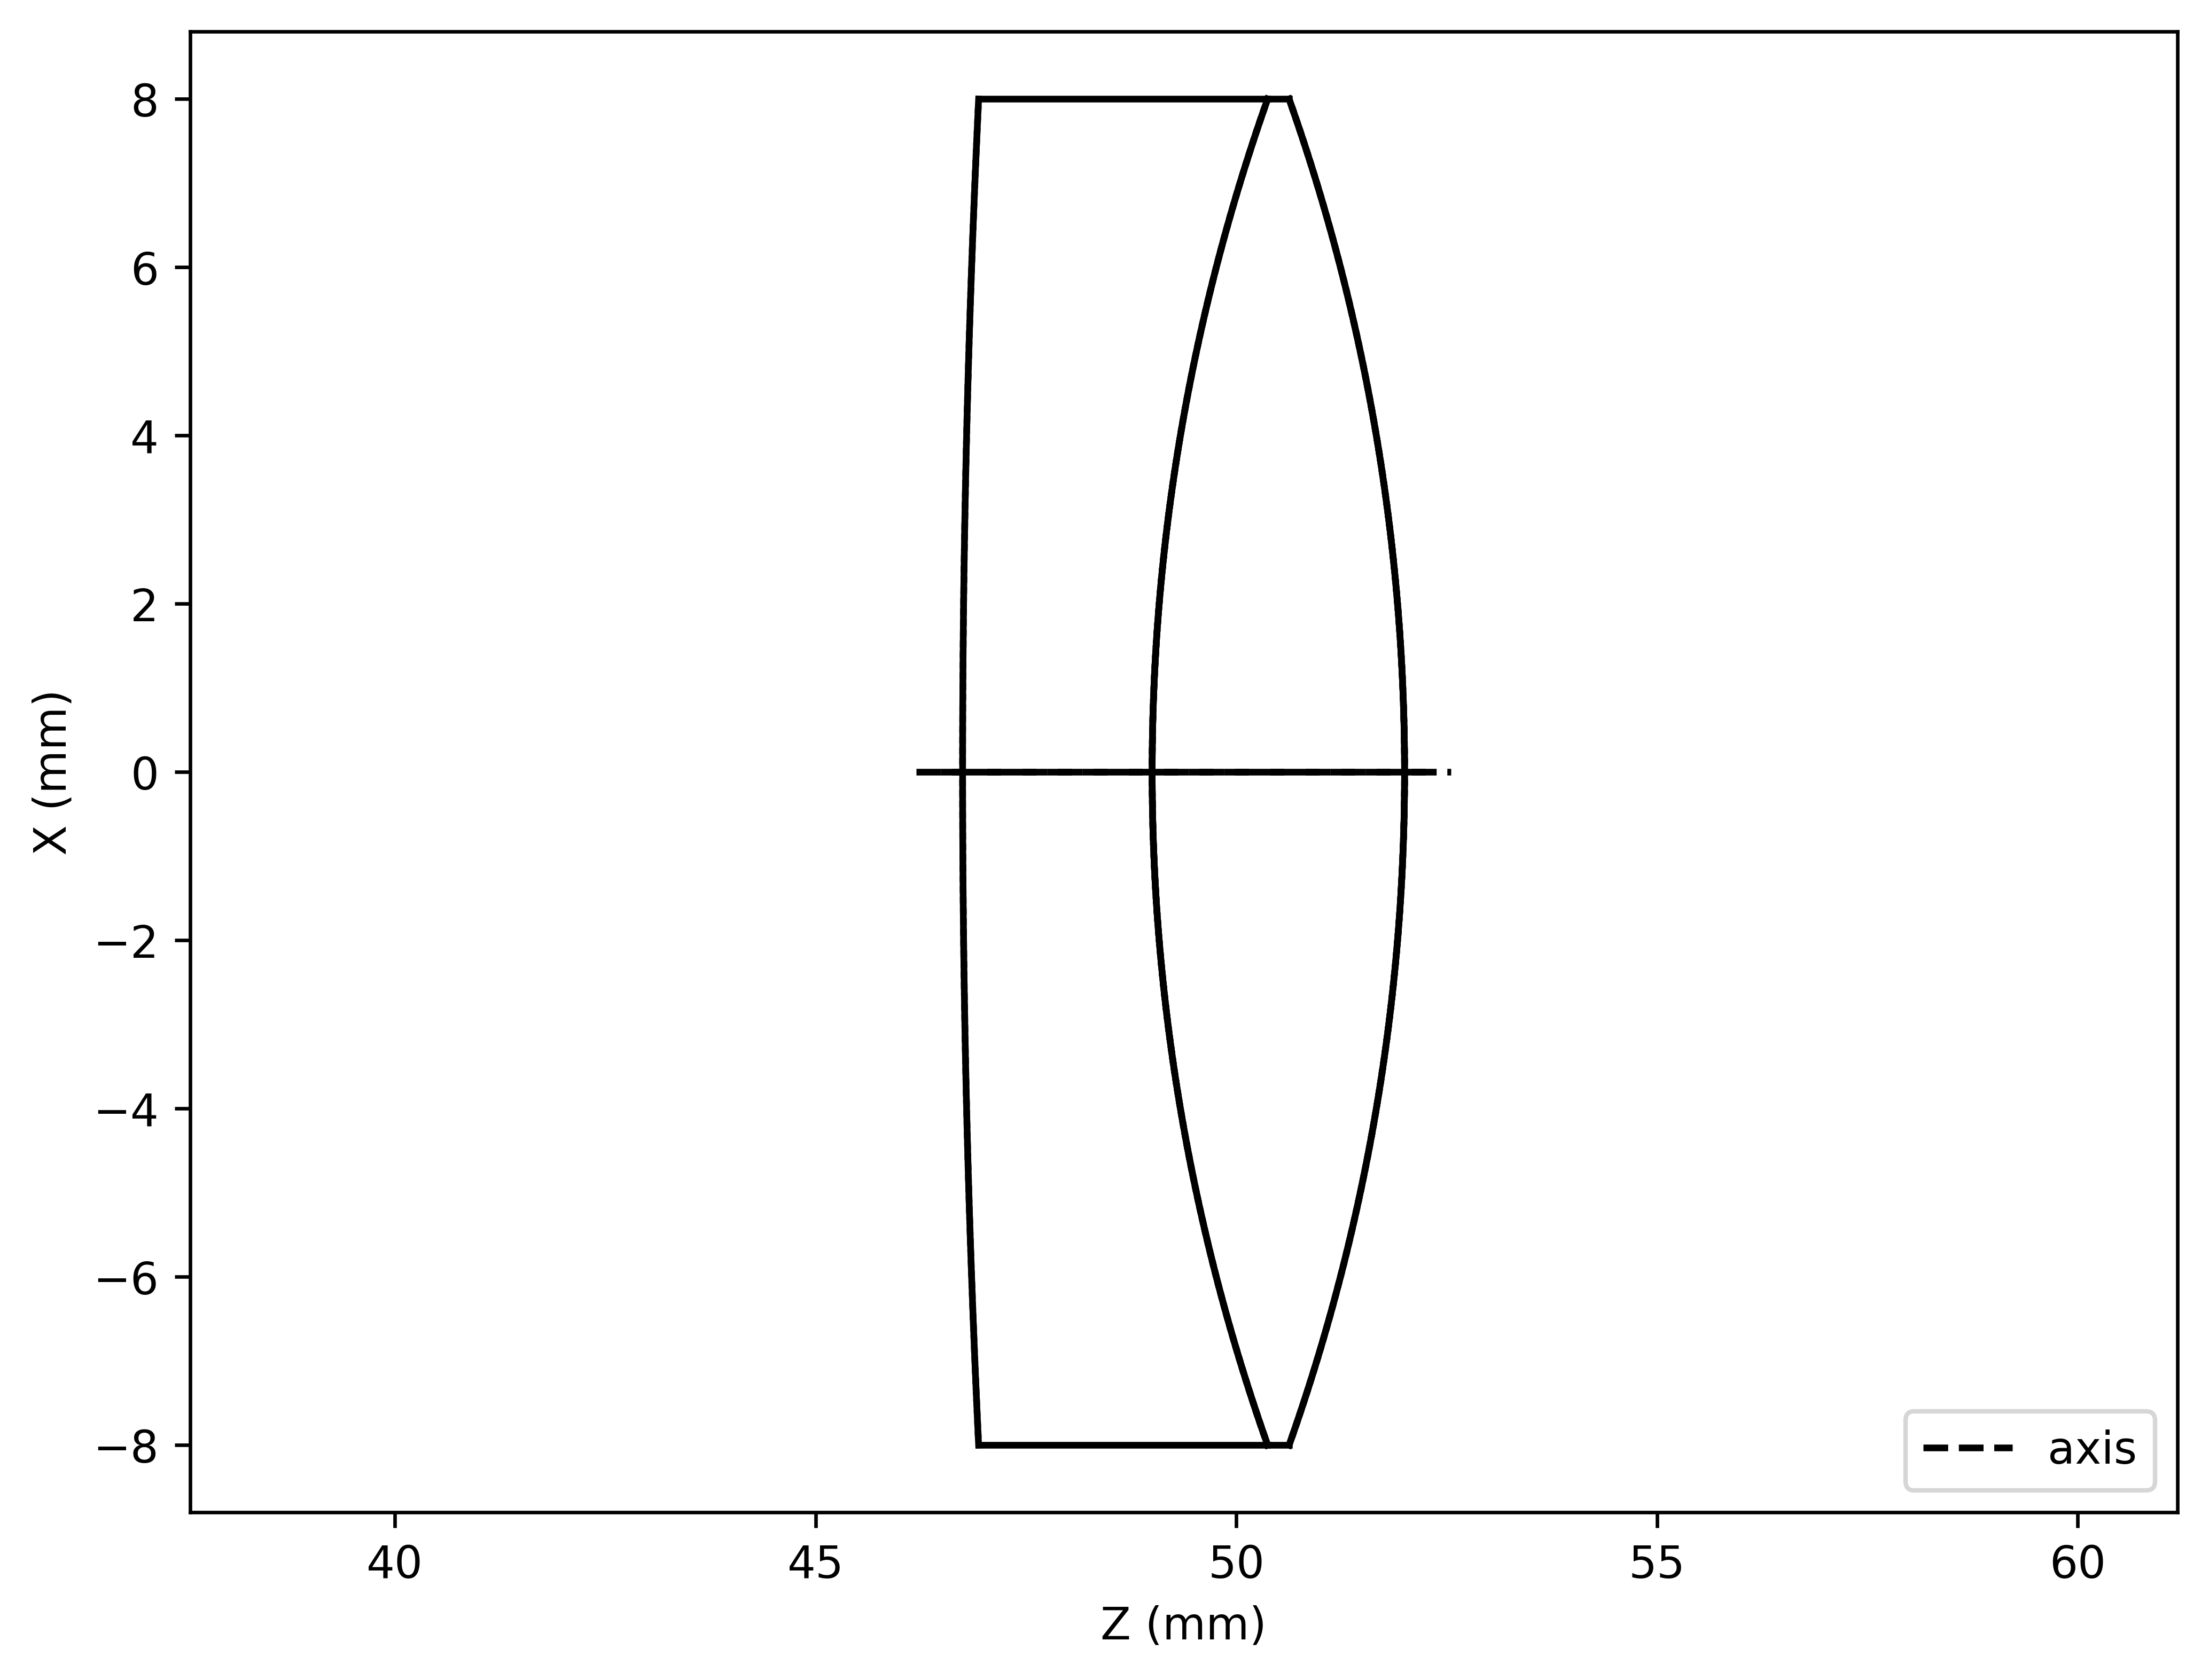

In [5]:
from scripts.lens_design.lens import ConicSurface, EvenAsphericSurface, LensMaterial, LensSystem
import numpy as np

surfs = [
        { 'radial_extent': 8.0, 'c':  1/140, 'z0': 48 },
        { 'radial_extent': 8.0, 'c':  -1/24, 'z0': 49 },
        { 'radial_extent': 8.0, 'c':   1/24, 'z0': 52 },
        ]

surfaces = [ConicSurface(K=0, **surf) for surf in surfs]
materials = [
        # LensMaterial("sf11", 1.7847, 25.76),
        LensMaterial("sf11", 1.6447, 0.2*64.17),
        LensMaterial("nbk7", 1.5168, 0.2*64.17), 
        ]
# aperture_index = len(surfaces) - 1
aperture_index = -1
lens_system = LensSystem(surfaces, materials, aperture_index=aperture_index)

target_focal_length = 50.0
lens_system.disable_all_surfaces()
# lens_system.disable_all_materials()
lens_system.disable_material_vars("ior")
lens_system.disable_var_in_material("V_d", 2)

# apply focal length constraint
s1_params = lens_system.get_rear_surface_params(target_focal_length)
lens_system.elements[0].surface.params['c'] = s1_params['c'].numpy().item()
lens_system.elements[0].surface.params['z0'] = s1_params['z0'].numpy().item()
lens_system.compute_paraxial_quantities()
Vd_exact = get_exact_Vd(lens_system)
print(f"Exact Vd: {Vd_exact}")

assert                                            0 < lens_system.elements[0].surface.params['z0']
assert lens_system.elements[0].surface.params['z0'] < lens_system.elements[1].surface.params['z0']
assert lens_system.elements[1].surface.params['z0'] < lens_system.elements[2].surface.params['z0']

fig = plt.figure(figsize=(8,6), dpi=600)
_ = lens_system.draw_cross_section(64,fig=fig)

In [6]:
lens_system.print()


====== Materials ======
mat[0]: 1.456079838959f, 0.021086562958f
mat[1]: 1.568952539042f, 0.026305160873f
mat[2]: 1.000277000000f, 0.000000000000f

====== Geometry ======
r_c: 24.00000000f, -24.00000000f, -168.01068267f
  t: 3.00000000f, 2.25291824f, 46.74708176f
r_e: 8.00000000f, 8.00000000f, 8.00000000f


[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle0.ply
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens1.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle1.ply
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens2.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle2.ply
[0.0003799945116043091]
y is close:  False
[8.578179404139519e-06]
u is close:  True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


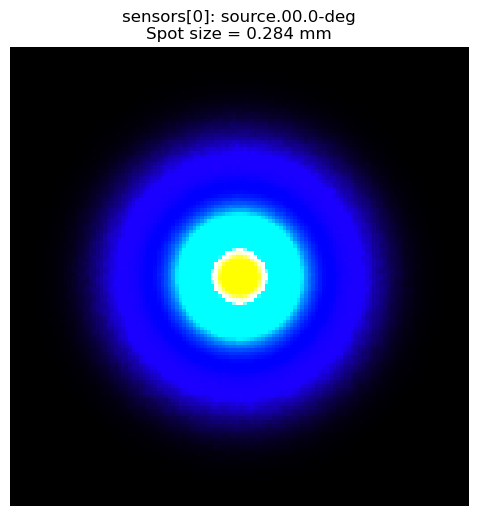

In [7]:
from scripts.lens_design.design_problem import DesignProblem

problem = DesignProblem(
    lens_system,
    resolution=(128, 128),
    spp=64*4*2,
    learning_rate=3e-1*0.4,
    iters=250,
    output_dir=output_dir,
    init_camera_z=0.01,
    )

problem.prepare()
problem.plot_spots(scale=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 127.5, 127.5, -0.5)

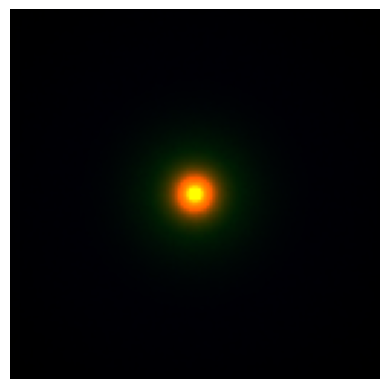

In [8]:
img = problem.render(spp = 512, resolution = (128, 128), zoom_factor=2, sensor_idx=0)
img /= 0.05 * dr.max(img)
plt.imshow(img)
plt.axis('off')

In [9]:
problem.optimizer.variables

{'mat_sf11_V_d': [12.833999633789062]}

In [10]:
# spots_init = problem.render(spp = 512, resolution = (1024, 1024), zoom_factor=0.1, sensor_idx=0)
# plt.figure(figsize=(12,12))
# plt.imshow(spots_init)

# # mi.util.write_bitmap("spots_.exr", spots_init)

In [11]:
losses, images_final, images_init, upsample_steps, sizes_init, sizes_final, Vd_list = problem.optimize(True)

import numpy as np

Vd_list = np.concatenate(Vd_list)

Iter 14: upsampling to level 1 due to loss[0] = 536.2243041992188
Iter 15: upsampling to level 2 due to loss[0] = 128.98878479003906
Iter 66: upsampling to level 3 due to loss[0] = 28.270231246948242
Iter 67: upsampling to level 4 due to loss[0] = 5.063572883605957


Vd_final: [7.060338]
Final error: [0.19874382]


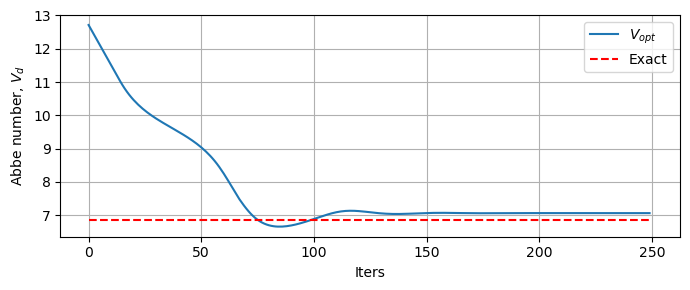

In [12]:
plt.figure(figsize=(7,3))
plt.plot(Vd_list, label=r"$V_{opt}$")
plt.plot([0, Vd_list.size], [Vd_exact, Vd_exact], 'r--', label="Exact")
plt.xlabel("Iters")
plt.ylabel(r"Abbe number, $V_{d}$")
plt.legend()
plt.grid("on")
# plt.title("Doublet optimization")
# plt.ylim([0, 65])
plt.tight_layout()

print("Vd_final:", Vd_list[-1])
print("Final error:", Vd_list[-1] - Vd_exact)

In [13]:
# spots_final = problem.render(spp = 512, resolution = (1024, 1024), zoom_factor=0.1 / 2 ** upsample_steps)
# plt.figure(figsize=(12,12))
# plt.imshow(0.1 * spots_init)
# plt.figure(figsize=(12,12))
# plt.imshow(0.1 * spots_final)

# # mi.util.write_bitmap("spots.exr", spots_final)

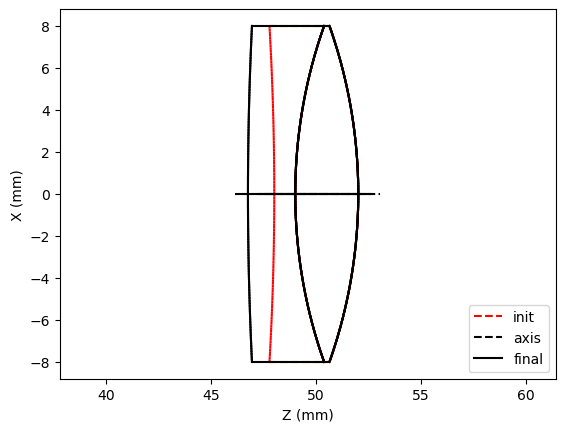

In [14]:
# plt.legend()
lens_init = LensSystem([ConicSurface(K=0, **surf) for surf in surfs], materials, aperture_index=aperture_index)
fig = lens_init.draw_cross_section(64, color='r', linestyle='--', label="init")
_ = lens_system.draw_cross_section(64, color='k', fig=fig, label='final')
# c = 60.84
# dx = 0.01
# dy = 0.01
# plt.xlim([c-dx,c+dx])
# plt.ylim([-dy,dy])

In [15]:
print(f"Upsampling steps: {upsample_steps}")

Upsampling steps: 4


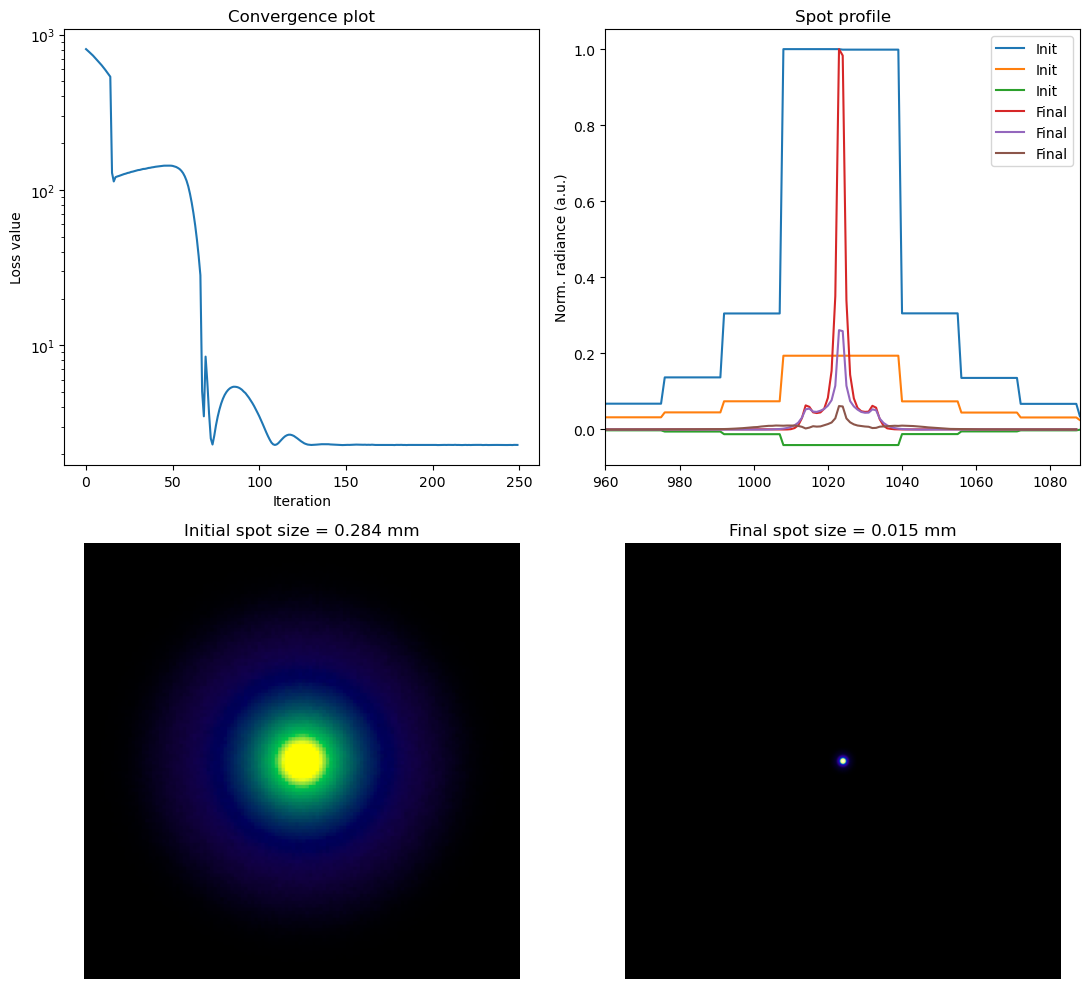

In [16]:
from scripts.lens_design.design_problem import plot_progress

for image_i, image_f, spot_size_init, spot_size_final in zip(images_init, images_final, sizes_init, sizes_final):
    _ = plot_progress(image_i, image_f, spot_size_init, spot_size_final, losses, upsample_steps, False)
    # mi.util.write_bitmap("spot_i.exr", image_i)
    # mi.util.write_bitmap("spot_f.exr", image_f)


In [17]:
print(materials[0].params)
print(materials[1].params)

{'ior': 1.6447, 'V_d': [7.060323238372803]}
{'ior': 1.5168, 'V_d': 12.834000000000001}


In [18]:
from scripts.lens_design.lens import abbe_to_cauchy

print(abbe_to_cauchy(1.6447, 0.2*64.17))
print(abbe_to_cauchy(1.5168, 0.2*64.17))
print(abbe_to_cauchy(1.6447, 7.06033992767334))
print(abbe_to_cauchy(1.6447, Vd_exact))

(1.5689525390422485, 0.0263051608728981)
(1.4560798389592584, 0.021086562958141358)
(1.507009332993809, 0.04781645616233479)
(1.5030211256389316, 0.04920145883751409)


In [19]:
for m in problem.lens_system.materials:
    print(m.params)
print(problem.lens_system.elements[0].surface.params)
print(problem.lens_system.elements[1].surface.params)

lens_system.print()

lens_system.materials[1].params['V_d'] = Vd_exact

lens_system.print()


{'ior': 1.000277, 'V_d': 0.0}
{'ior': 1.6447, 'V_d': [7.060323238372803]}
{'ior': 1.5168, 'V_d': 12.834000000000001}
{'c': -0.04761601984500885, 'K': 0, 'z0': 46.7470817565918}
{'c': -0.3333333333333333, 'K': 0, 'z0': 49}

====== Materials ======
mat[0]: 1.456079838959f, 0.021086562958f
mat[1]: 1.507009029388f, 0.047816570848f
mat[2]: 1.000277000000f, 0.000000000000f

====== Geometry ======
r_c: 24.00000000f, -24.00000000f, -168.01068267f
  t: 3.00000000f, 2.25291824f, 46.74708176f
r_e: 8.00000000f, 8.00000000f, 8.00000000f

====== Materials ======
mat[0]: 1.456079838959f, 0.021086562958f
mat[1]: 1.503021125639f, 0.049201458838f
mat[2]: 1.000277000000f, 0.000000000000f

====== Geometry ======
r_c: 24.00000000f, -24.00000000f, -168.01068267f
  t: 3.00000000f, 2.25291824f, 46.74708176f
r_e: 8.00000000f, 8.00000000f, 8.00000000f
